# Intro Scalable Deep Learning: Day 4, Tutorial 1

**Content creators**: Mehdi Cherti

**Content reviewers / testers**: Jenia Jitsev, Roshni Kamath, Jan Ebert

**Content supervisors** : Jenia Jitsev

# Tutorial Objectives

We have seen in **day 3** that for various reasons, peformance can deteriorate when scaling
the batch size. In this tutorial, you will learn how to deal with performance deterioration
using different mechanisms that have been shown experimentally to help keeping
the same performance as the baseline training with one worker.

- You will learn how to use the linear scaling rule, a simple scaling rule for the learning rate, to compensate for increasing the effective batch size $\vert \mathfrak{B} \vert = K \vert B_{local} \vert$ when using $K$ workers for data parallel distributed training (**Exercise 1**).
- You will learn how to use different learning rate schedules: step-wise decay and 1-cycle schedule (**Exercise 2**).
- You will learn how to use the warmup strategy to avoid explosion of the loss during the beginning of training (**Exercise 3**).
- You will learn how to use more sophisticated optimizers, LARS ([You, Gitman, et al.](https://arxiv.org/abs/1708.03888)) and LAMB ([You, Li, et al.](https://arxiv.org/abs/1904.00962)), which are specifically designed for distributed training with large batch sizes (**Exercise 4**).

# Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_learning_curves(path, metric='accuracy'):
    """
    path: str
        Path to CSV with results of training
    metric: str
        metric to  display (options: 'accuracy' or 'loss')
    """
    df = pd.read_csv(path)
    plt.plot(df['epoch'], df[metric], label=f'train {metric}')
    plt.plot(df['epoch'], df[f'val_{metric}'], label=f'valid {metric}')
    plt.xlabel('epoch')
    plt.legend()
    plt.title(f'Filename: {path}')
    plt.show()

    
def plot_multiple_learning_curves(paths, metric='val_accuracy'):
    """
    paths: list of str
        list of CSV file paths from different runs to display together
        in a plot
    metric: str
        metric to  display (options: 'accuracy' or 'loss')
    """
    for i, path in enumerate(paths):
        df = pd.read_csv(path)
        basename = os.path.basename(path)
        plt.plot(df['epoch'], df[metric], label=basename)
        plt.xlabel('epoch')
        plt.ylabel(metric)
    plt.legend()
    plt.show()


## Exercise 1: Increase in effective batch size


### Intro

In data parallel distributed training, we contrast between the **local batch size** $\vert B_{local} \vert$ and the **effective batch size** $\vert \mathfrak{B} \vert$.
The **local batch size** is the batch size used within each worker (one worker = one GPU).
After the forward pass, within each worker, the gradients of the loss with respect to the parameters $\frac{\delta \mathcal{L}_{B}}{\delta W}$ are computed. The gradients of each worker are then aggregated across all workers with the `allreduce` operation and averaging is performed, such that all the workers receive the same aggregated averaged gradients version. Afterwards, within each worker, the weights of the neural network are updated with stochastic gradient descent (SGD) or its variants (e.g. Adam, RMSProp) using the averaged aggregated gradients.

The weight update that is done is equivalent to using one worker
with a batch size of **local batch size * number of workers**, which we call the **effective batch size**, $\vert \mathfrak{B} \vert = K \vert B_{local} \vert$.

By using more workers, we are also scaling the batch size which is used to update the parameters, hence the term **effective batch size**. 
However, it can be shown experimentally that, everything else being equal, scaling the batch size can result in training and/or validation performance degradation (see related work section of [Lin et al.](https://arxiv.org/abs/1808.07217) for a list of references). Scaling the batch size often requires retuning the learning rate and changing the learning rate schedule to keep the same performance in training and validation sets.

In this first exercise, you will first observe yourself the degradation caused by using
a large effective batch size **(Task 1.1)**.

As a solution, you will use a simple linear rescaling of the learning rate used
by [Goyal et al.](https://arxiv.org/abs/1706.02677) to solve the problem **(Task 1.2)**.  

The linear scaling rule of the learning rate is the following:
if you scale the number of workers $K$ times,
multiply the learning rate $\eta$ by $K$.
For instance, if you use 1 GPU and a learning rate $\eta_{base} = 0.1$, for 16 GPUs, use a learning
rate $\eta = 16 \times 0.1 = 1.6$.

The reasoning behind this rule is that if you keep the same number of epochs, and use a batch size $\vert \mathfrak{B} \vert = nK$ instead of $\vert B_{local} \vert = n$, you will end up doing $K$ times less parameter update steps. To compensate for having $K$ times less parameter updates, we multiply the learning rate $\eta$ by the number $K$.
More details about the reasoning behind the linear scaling rule is provided in [Goyal et al.](https://arxiv.org/abs/1706.02677) and [Bottou et al.](https://arxiv.org/abs/1606.04838)

In the following, we will use a base learning rate $\eta = 0.1$, and we will use 2 nodes and 4 GPUs per node, leading to a total of $K=8$ GPUs.

### Task 1.1

- Train a first time with a local batch size $\vert B_{local} \vert = 64$  (this results in effective batch size $\vert \mathfrak{B} \vert = 64 \times 8 = 512$ for 8 GPUs).
- Train a second time with a local batch size of $\vert B_{local} \vert = 512$ (this results in $\vert \mathfrak{B} \vert = 512 \times 8 = 4096$ for 8 GPUs).
- Plot the training/validation loss and accuracy curves for both the runs together in order to compare them, using `plot_learning_curves('task1.1_bs64.csv')` and `plot_learning_curves('task1.1_bs512.csv')`.

For running the training on each case, use `sbatch run_task1.1.sh BATCH_SIZE`, where `BATCH_SIZE` is the local batch size.
After finishing the training, the results will be written into `task1.1_bs{BATCH_SIZE}.csv`.

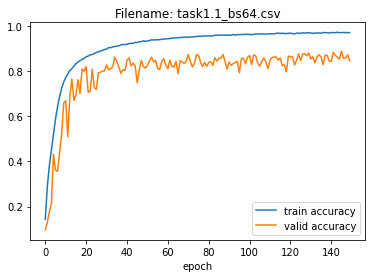

In [2]:
plot_learning_curves('task1.1_bs64.csv')

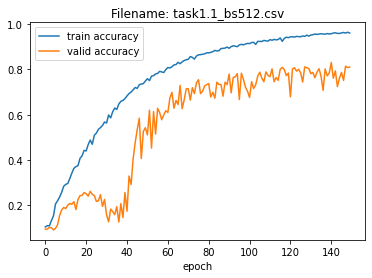

In [3]:
plot_learning_curves('task1.1_bs512.csv')

### Task 1.2

- Implement the linear scaling rule of the learning rate in `train.py` and redo both trainings of **Task 1.1** (local batch sizes $\vert B_{local} \vert = 64$ and $\vert B_{local} \vert = 512$). The implementation consists in multiplying the learning rate $\eta$ (here $\eta = 0.1$) by the number of workers `hvd.size()` (one worker = one GPU in our case).
Please write the implementation in the relevant part of `train.py` after `if args.enable_lr_rescaling`.
- Re-plot the training/validation loss and accuracy curves for both the runs together in order to compare them, using `plot_learning_curves('task1.2_bs64.csv')` and `plot_learning_curves('task1.2_bs512.csv')` .

For running the training on each case, use `sbatch run_task1.2.sh BATCH_SIZE`, where `BATCH_SIZE` is the local batch size.
After finishing the training, the results will be written into `task1.2_bs{BATCH_SIZE}.csv`.

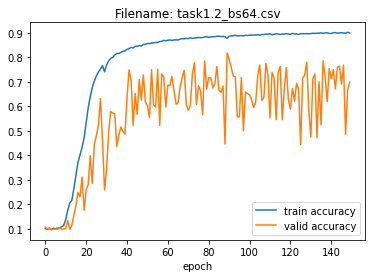

In [4]:
plot_learning_curves('task1.2_bs64.csv')

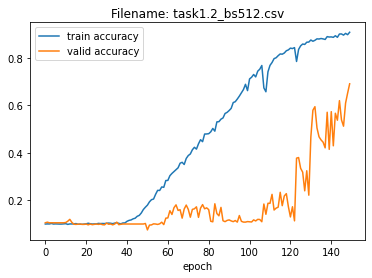

In [5]:
plot_learning_curves('task1.2_bs512.csv')

## Exercise 2: Learning rate schedules

### Intro
The simple linear scaling rule of the learning rate (see **Exercise 1**) is usually not sufficient
by itself, especially with very large batch sizes.

In this exercise, in addition to the linear scaling rule, you will implement different learning rate schedules.
Stochastic gradient descent (SGD) relies on a noisy estimation of the gradient of the loss with respect to the parameters $\frac{\delta \mathcal{L}}{\delta W}$. The noise is introduced because the gradients are estimated
from a small sample of the data instead of the full data. As the gradients are noisy, using them in optimization can introduce oscillations in training/validation performance. In order to not suffer from those oscillations and converge, the learning rate is usually decreased over time. Note that there are also more sophisticated schedules, such as cyclic learning rate schedules, which alternate between increasing learning rate and decreasing it.

One of the most used learning rate schedules is the step-wise schedule. In the step-wise schedule the learning rate
is divided by a constant value $\gamma$ in specific epochs or every $N$ epochs. A theoretical motivation of the step-wise
schedule is provided in [Bottou et al.](https://arxiv.org/abs/1606.04838)

### Task 2.1

Use the `train.py` code from **Exercise 1** with the linear scaling rule and implement a step-wise learning rate schedule.
It can be implemented using a Keras callback https://keras.io/api/callbacks/learning_rate_scheduler/.
The schedule is basically a function that takes the current learning rate `lr` and the current epoch `epoch`, then
returns the learning rate for that epoch.

```python
def step_wise_decay(epoch, lr):
    """
    epoch: int
        Current epoch
    lr: float
        Current learning rate
    
    Returns
    -------
    float
        Learning rate at epoch `epoch`
    """
    [...]
```

- Implement `step_wise_decay` by dividing the learning rate by $\gamma = 10$ at epoch 80 and epoch 120. Please fill the function `step_wise_decay` in `train.py`.
- Launch the training using `sbatch run_task2.1.sh 64` and compare with the results of **Exercise 1** (same procedure `plot_learning_curves` for plotting).
    - We use the same initial base learning rate as in **Exercise 1**, $\eta = 0.1$.
    - We fix the local batch size $\vert B_{local} \vert = 64$.
    - We use `step_wise_decay` as a learning rate scheduler.


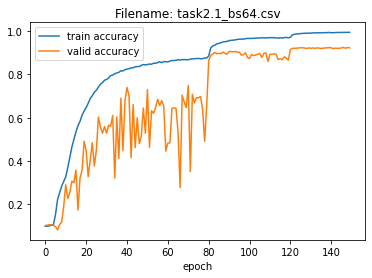

In [6]:
plot_learning_curves('task2.1_bs64.csv')

### Task 2.2

[Smith et al.](https://arxiv.org/abs/1708.07120) introduced the **1-cycle** learning rate schedule and shows
we can train with very high learning rates and reach high accuracy very quickly
(phenomenon they call **super-convergence**).

![Figure from https://sgugger.github.io/the-1cycle-policy.html](1cycle_lr.png)

(Figure from: https://sgugger.github.io/the-1cycle-policy.html)

In the **1-cycle** learning rate schedule, there are three phases:
1. In the first phase, we start from a low learning rate, and increase it
up to a maximum learning rate after a fixed number of steps.
2. The second phase is symmetric to the first one, where we instead decrease
the learning rate until we reach the starting learning rate
used in the first phase, with the same number steps.
3. In the third phase and last phase, we continue decaying the learning rate
until we reach a fraction (e.g. $0.1$) of the starting learning
rate. [Smith et al.](https://arxiv.org/abs/1708.07120) suggest further
to apply this schedule to momentum as well in a reverse way,
the momentum starts high, decreases, then increases again.


- As a maximum learning rate for the 1-cycle schedule, use the rescaled learning rate. (if curious, see `clr.py` for more info on scheduler settings). Fill the `max_lr` argument of the `OneCycleLR` instantiation in `train.py`
- Launch the training using `sbatch run_task2.2.sh 64` and compare with the results of **Task 2.1** (same procedure `plot_learning_curves` for plotting).
    - We use the same initial base learning rate as in **Exercise 1**, $\eta = 0.1$.
    - We use the local batch size $\vert B_{local} \vert=64$.
    - We use `clr` as a learning rate scheduler.

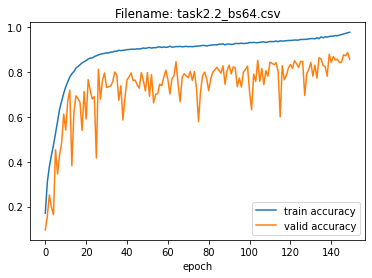

In [7]:
plot_learning_curves('task2.2_bs64.csv')

## Exercise 3: Warmup

As noted by [Goyal et al.](https://arxiv.org/abs/1706.02677), the high learning rates that
result from the linear scaling rule can make the loss explode in the beginning because the gradient
magnitude can be high. In order to prevent loss explosion, it is possible to use the **warmup** strategy,
where the learning rate starts with a low value and is gradually increased to the
actual initial value that is desired. Note that it is similar to the first phase 
of the 1-cycle learning rate schedule.

Warmup has been used in conjunction with the linear scaling of learning rate
to achieve performance similar to the baseline (batch size 256)
with an effective batch size $\vert \mathfrak{B} \vert \approx 8\,000$ for ImageNet training,
according to [Goyal et al.](https://arxiv.org/abs/1706.02677) It was also used to train OpenAI's GPT models.

- Implement the gradual warmup strategy by linearly increasing the learning rate from a minimum value `min_lr` to the desired initial learning rate during the first 5 epochs. The rest of the schedule
should remain the same. Following [Goyal et al.](https://arxiv.org/abs/1706.02677), start the warmup with $\text{min_lr} = \eta$ and finish with $\eta * K$ ($K$ being the number of workers provided by `hvd.size()`) at the 5th epoch, where $\eta = 0.1$ is the base initial learning rate. Please fill the function `step_wise_decay_with_warmup` in `train.py`.
- Launch the training using `sbatch run_task3.sh 512` and compare with the results of **Exercise 1**.
    - We use the same initial base learning rate as in **Exercise 1**, $\eta = 0.1$.
    - We fix the local batch size $\vert B_{local} \vert = 512$, leading to an effective batch size
of $512 \times 8 = 4096$.
    - We use `step_wise_decay_with_warmup` as a learning rate scheduler.

- Compare the training/validation performance with/without the warmup strategy (same procedure `plot_learning_curves` for plotting).

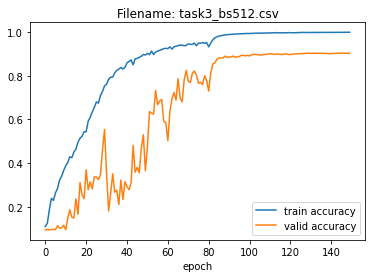

In [8]:
plot_learning_curves('task3_bs512.csv')

## Exercise 4: Advanced optimizers

### Intro

In [Goyal et al.](https://arxiv.org/abs/1706.02677), the linear scaling rule
of the learning rate with warmup can achieve the same performance 
as the reference training up to an effective batch size of $\vert \mathfrak{B} \vert \approx 8\,000$.
Starting from $\vert \mathfrak{B} \vert \approx 8\,000$, we start to see again performance deterioration.
Large learning rates resulting from the linear scaling rule
make the training instable. In this exercise, we will explore
advanced optimizers that mitigate this problem.



### Task 4.1

In LARS ([You, Gitman, et al.](https://arxiv.org/abs/1708.03888)), they observe
that the ratio of the weights' magnitude to the gradient's magnitude $\frac{\parallel W \parallel}{\parallel \frac{\delta \mathcal{L}}{\delta W} \parallel}$ varies significantly between different layers,
and high learning rates (e.g. when using the linear scaling rule) on the layers with large gradient magnitudes 
can make the training instable, even with warmup. 
They propose to have a global learning rate $\eta$ and a learning rate per layer $\eta_l$.
The learning rate per layer $\eta_l$ is computed by scaling
the global learning rate $\eta$ by $\frac{\parallel W \parallel}{\parallel \frac{\delta \mathcal{L}}{\delta W} \parallel}$.
In other words, if the gradients are large compared to the weights, we scale down the learning
rate per layer to avoid instabilities. On the other hand, if the gradients are small compared to the weights,
we scale the learning rate per layer up. Another way to understand it is the following: we first normalize the gradient to unit norm by dividing by its magnitude $\parallel \frac{\delta \mathcal{L}}{\delta W} \parallel$, then we multiply by the magnitude of the weights $\parallel W \parallel$ so that the weight updates are in the same order as the weights themselves, which is desirable to avoid instability during training.

In LARS ([You, Gitman, et al.](https://arxiv.org/abs/1708.03888)), they were able to keep
approximately the same performance up to an **effective batch size $\vert \mathfrak{B} \vert \approx 32\,000$**.

- Fill the relevant parts of `run_task4.1.sh`:
    - Use the same initial base learning rate as in **Exercise 1**, $\eta = 0.1$.
    - Use `step_wise_decay_with_warmup` as a learning rate scheduler.
    - Use `LARS` as an optimizer.
- Train the model with $\vert B_{local} \vert = 512$ ($\vert \mathfrak{B} \vert = 512 \times 8 = 4096$) using `sbatch run_task4.1.sh 512`. Compare with **Exercise 3** results (same procedure `plot_learning_curves` for plotting).
- Train the model with $\vert B_{local} \vert = 1024$ ($\vert \mathfrak{B} \vert = 1024 \times 8 = 8192$) using `sbatch run_task4.1.sh 1024`. Compare with the results with a local batch size of 512 (same procedure `plot_learning_curves` for plotting).



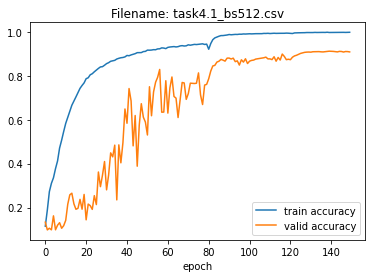

In [9]:
plot_learning_curves('task4.1_bs512.csv')

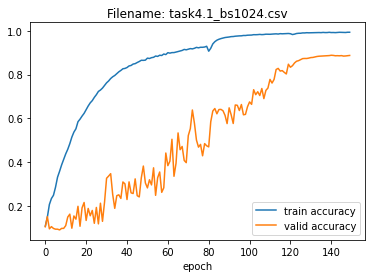

In [10]:
plot_learning_curves('task4.1_bs1024.csv')

### Task 4.2

In LAMB ([You, Li, et al.](https://arxiv.org/abs/1904.00962)), LARS ([You, Gitman, et al.](https://arxiv.org/abs/1708.03888)) is extended by introducing per-parameter learning rates like ADAM ([Kingma et al.](https://arxiv.org/abs/1412.6980)) while also keeping per-layer learning rates.
We compute the moving average of the gradients (first moment) as well as the moving average of the square of the gradients (second moment), and use them to compute a per-parameter update
$$ r_t = \frac{m_t}{\sqrt{v_t} + \epsilon}, $$
where $m_t$ represents the exponential moving average of the first moment of the gradient and $v_t$ the exponential moving average of the second moment of the gradient, exactly like ADAM ([Kingma et al.](https://arxiv.org/abs/1412.6980)). Afterwards, we rescale $r_t$ using the ratio of the magnitude of the weights to the magnitude of the updates computed for each layer separately, similar to LARS ([You, Gitman, et al.](https://arxiv.org/abs/1708.03888)).

- Start from the solution of **Task 4.2**, and replace **LARS** by **LAMB** which is avaiable in `lamb.py`, use a base learning rate $\eta = 0.001$ instead of $\eta = 0.1$ and keep everything else the same.
- Train the model with $\vert B_{local} \vert = 512$ ($\vert \mathfrak{B} \vert = 512 \times 8 = 4096$) using `sbatch run_task4.2.sh 512`. Compare with **Task 4.1** (same procedure `plot_learning_curves` for plotting).
- Train the model with $\vert B_{local} \vert = 1024$ ($\vert \mathfrak{B} \vert = 1024 \times 8 = 8192$) using `sbatch run_task4.2.sh 1024`. Compare with the results with local batch size of 512 and with **Task 4.1** (same procedure `plot_learning_curves` for plotting).

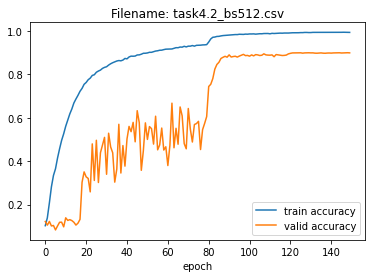

In [11]:
plot_learning_curves('task4.2_bs512.csv')

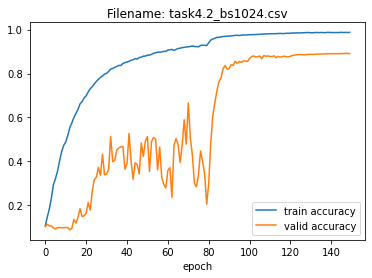

In [12]:
plot_learning_curves('task4.2_bs1024.csv')

# Summary

In this tutorial, we have seen that using a larger effective batch size does not come for free, it is necessary to adjust other aspects of the training to keep the performance as good as the baseline. We learned that a simple
way to compensate for large batch size is to scale the learning rate. However, scaling the learning rate naively can cause some instability issues in the training. We have seen different techniques to prevent instability such as warmup and using optimizers such as LARS and LAMB.

In [13]:
files = [
 'task1.1_bs512.csv',
 'task1.2_bs512.csv',
 'task2.1_bs512.csv',
 'task2.2_bs64.csv',
 'task3_bs512.csv',
 'task4.1_bs512.csv',
 'task4.1_bs1024.csv',
 'task4.2_bs512.csv',
 'task4.2_bs1024.csv',
]
metric = 'val_accuracy'
rows = []
for f in files:
    df = pd.read_csv(f)
    rows.append({'task': f.replace('.csv', ''), metric:df[metric].iloc[-1]})
df = pd.DataFrame(rows)
df.sort_values(by='val_accuracy')

,task,val_accuracy
1,task1.2_bs512,0.691025
2,task2.1_bs512,0.806150
0,task1.1_bs512,0.810075
3,task2.2_bs64,0.858325
6,task4.1_bs1024,0.887325
8,task4.2_bs1024,0.890825
7,task4.2_bs512,0.899700
4,task3_bs512,0.903050
5,task4.1_bs512,0.909075


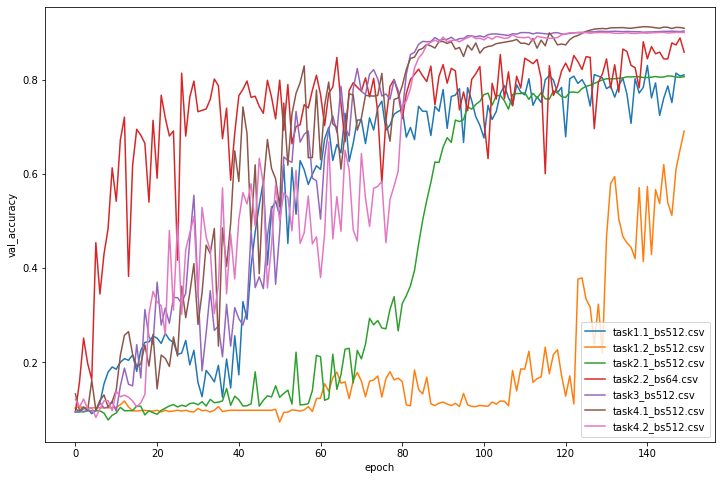

In [14]:
fig = plt.figure(figsize=(12,8))
plot_multiple_learning_curves([
   'task1.1_bs512.csv',
   'task1.2_bs512.csv',
   'task2.1_bs512.csv',
   'task2.2_bs64.csv',
   'task3_bs512.csv',
   'task4.1_bs512.csv',
   'task4.2_bs512.csv',
], metric='val_accuracy')